In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)


train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Using custom data configuration default-31dfe7adddcf5ced
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 182.19it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ad71be204b279b28.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e7b6b615907c24ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-bee802838a3bfaea.arrow


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 

In [4]:
columns_to_keep = ["claim", "premise", "label","category"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

100%|██████████| 234/234 [00:00<00:00, 6987.32ex/s]

Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [6]:
labels = np.array(dataset['train']['label'])

In [7]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='bioformers/bioformer-8L-mnli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        premise = item['premise'].replace('\n', '').replace('[','').replace(']','')
        item['claim']=claim
        item['premise']=premise
        
        # Tokenize the texts
        inputs = self.tokenizer(
            claim, premise,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        if 'label' in item:
            item['labels'] = torch.tensor(item['label'], dtype=torch.long)
        
        return item



In [8]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [9]:
model_name = "bioformers/bioformer-8L-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [11]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category'],
    num_rows: 1623
})

In [12]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()


In [13]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [14]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [15]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [16]:
tdata.__getitem__(0)

{'claim': 'Myrrh essential oil is sometimes used in skincare products to help improve the appearance of the skin.',
 'premise': '; UnkoviÄ‡, N.; DimkiÄ‡, I.; JanaÄ‡koviÄ‡, P.; GavriloviÄ‡, M.; StanojeviÄ‡, O.; VukojeviÄ‡, J. Frankincense and myrrh essential oils and burn incense fume against micro-inhabitants of sacral ambients.Shameem, I. Phytochemical & therapeutic potentials of Murr makki (.Oxidative stress and immunotoxic effects of lead and their amelioration with myrrh (Commiphora molmol) emulsion.Essential Oils: Magical Ingredients for Skin Care.Chakravarty, N.; Kellogg, C.; Alvarez, J.; Equils, O.; Morgan, M. UV Protection by Natural Products: C. myrrha Oil Versus Sunscreen.Hamidpour, R.; Hamidpour, S.; Hamidpour, M.; Shahlari, M. Frankincense (ä¹³é¦™ RÇ” XiÄ\x81ng;.species): From the selection of traditional applications to the novel phytotherapy for the prevention and treatment of serious diseases.Chemistry and immunomodulatory activity of frankincense oil.Compositions contai

In [17]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/11.2.1_bioformer/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/11.2.1_bioformer/best_model')
tokenizer.save_pretrained(f'/home/elson/11.2.1_bioformer/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.880300,0.818694,0.673118,0.338542,0.588802,0.673118,0.543776
2,0.701300,0.858568,0.612903,0.443502,0.637466,0.612903,0.613322
3,0.529500,0.882117,0.673118,0.519890,0.657715,0.673118,0.663985
4,0.250800,1.181990,0.638710,0.472135,0.643196,0.638710,0.637534
5,0.226000,1.329748,0.666667,0.473106,0.634186,0.666667,0.645418
6,0.184100,1.452106,0.645161,0.479947,0.635288,0.645161,0.639683
7,0.088500,1.699081,0.625806,0.498346,0.655606,0.625806,0.638274
8,0.037700,1.730931,0.655914,0.497460,0.648150,0.655914,0.651097
9,0.053300,1.744619,0.655914,0.505241,0.651823,0.655914,0.650900
10,0.039900,1.924265,0.643011,0.470848,0.626904,0.643011,0.634287


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
/home/elson/factcheck/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to /home/elson/11.2.1_bioformer/checkpoint-51
Configuration saved in /home/elson/11.2.1_bioformer/checkpoint-51/config.json
Model weights saved in /home/elson/11.2.1_bioformer/checkpoint-51/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/11.2.1_bioformer/checkpoint-102
Configuration saved in /home/elson/11.2.1_bioformer/checkpoint-102/config.json
Model weights saved in /home/elson/11.2.1_bioformer/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model c

/home/elson/factcheck/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Configuration saved in /home/elson/11.2.1_bioformer/best_model/config.json
Model weights saved in /home/elson/11.2.1_bioformer/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/11.2.1_bioformer/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/11.2.1_bioformer/best_model/special_tokens_map.json


('/home/elson/11.2.1_bioformer/best_model/tokenizer_config.json',
 '/home/elson/11.2.1_bioformer/best_model/special_tokens_map.json',
 '/home/elson/11.2.1_bioformer/best_model/vocab.txt',
 '/home/elson/11.2.1_bioformer/best_model/added_tokens.json',
 '/home/elson/11.2.1_bioformer/best_model/tokenizer.json')

In [18]:
model_path = "/home/elson/11.2.1_bioformer/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/11.2.1_bioformer/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/11.2.1_bioformer/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "mnli",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_siz

In [19]:
print(test_results)

PredictionOutput(predictions=array([[-0.5107,  0.723 , -0.7524],
       [-0.7485,  1.302 , -1.062 ],
       [-0.8477,  1.061 , -0.808 ],
       [-0.712 ,  1.047 , -0.841 ],
       [-0.6055,  1.003 , -0.9507],
       [-0.921 ,  1.415 , -0.979 ],
       [-0.518 ,  0.671 , -0.478 ],
       [-0.7983,  0.974 , -0.6445],
       [-0.466 ,  0.9956, -1.0625],
       [-0.465 ,  0.739 , -0.7114],
       [-0.821 ,  1.303 , -0.9985],
       [-0.518 ,  0.869 , -0.9604],
       [-0.6743,  0.9614, -0.8525],
       [-0.56  ,  0.6743, -0.5576],
       [-0.8745,  1.17  , -0.6797],
       [-0.613 ,  0.875 , -0.834 ],
       [-0.764 ,  1.048 , -0.627 ],
       [-0.6045,  0.711 , -0.6963],
       [-0.4458,  0.854 , -0.9375],
       [-0.4253,  0.8438, -1.    ],
       [-0.7344,  0.76  , -0.4885],
       [-0.5654,  0.7397, -0.693 ],
       [-0.769 ,  1.007 , -0.6914],
       [-0.3547,  0.5923, -0.749 ],
       [-0.5435,  0.7065, -0.6885],
       [-0.4517,  0.71  , -0.8086],
       [-0.549 ,  0.8286, -0.7544],

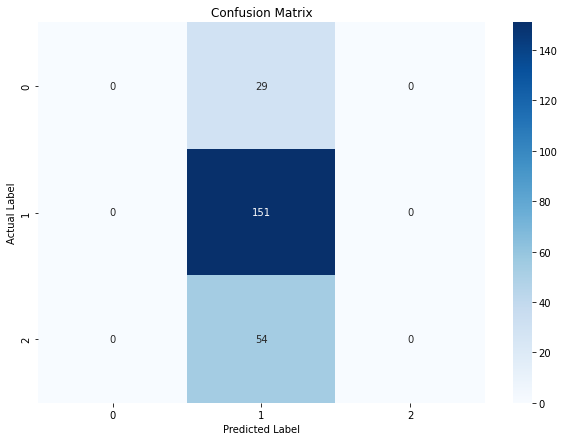

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [21]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/11.2.1_results.csv', index=False)

In [22]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [23]:
correct_classification_counts

General Health           35
Fitness                  13
Cancer                   12
Bone health              11
Skin                     10
Diabetes                  9
Throat                    9
Hair                      9
Neurological health       9
Cardiovascular Health     6
Ear                       6
COVID                     6
Eye                       5
Blood                     4
Women' s Health           2
Mental Health             2
Muscles                   2
Vascular                  1
Name: Category, dtype: int64

In [24]:
misclassification_counts

General Health           16
Skin                     14
Bone health              10
Men's health              6
Cardiovascular Health     6
Blood                     5
Eye                       4
Women' s Health           4
Muscles                   4
Dental Health             3
Hair                      3
Diabetes                  3
Fitness                   2
Vascular                  2
Mental Health             1
Name: Category, dtype: int64